# Problem Description
alles um tier GmBH is a pet supplies company. They are currently auditing their promotional activities and the CEO, one of the main stakeholders feels that the promotions they offer is too generic and not targetted. They have requested us to devise a <font color = 'red'>customer segementation model that they can use to run targetted promotional activities </font>

The client is interested in seeing what kind of customers are buying at alles um tier GmbH. They presume that there that there are also some smaller companies besides the private individuals who buy from alles um tier GmBH. The project scope is to build a segmentation model and analyze the resulting customer segments.

# Data

You are given a dataset at customer level for the last 2 years with the following data points: <br>
- Number of transactions in the last 2 years (num_transactions), 
- order amount (total_order_value), 
- days between transactions (days_between_trans), 
- re-order rate (repeat_share), 
- average order value (aov),
- % of dog products bought (is_dog_user)

### Data Set
The dataset consists of 100k rows and has the following columns:


- **CustomerID:** UUID for the customer (int)
- **num_transactions:** number of transactions in a given year (int)
- **total_order_value:** total order value in € for the time period (int)
- **days_between_trans :** average days between transactions for a user (int)
- **repeat_share:** product share repeated every order (float)
- is_dog_user: percentage of products ordered that are dog food related (float)

    
# Technical Environment
* Python
* numpy
* pandas
* scikit-learn
* matplotlib / searborn / altair / plotly

# Approach
The solution is assessed on the following skills:
* A thorough evaluation of the data set using statistical measures and visualization
* Elegant Python coding skills
* Machine Learning modelling fundamentals
* Machine Learning Training
* Model Evaluation

# Output
Please provide your solution in a jupyter notebook with clear markdown comments
The final output should be in the form of a dataframe with two columns user_id and label

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, ConfusionMatrixDisplay

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Simon-Kucher-dataset/Dataset.csv')
dataset = dataset.drop('Unnamed: 0', axis=1)
dataset

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
0,1217,399,41145.12,8,0.563256,0.699630,-1
1,7262,7,1454.80,41,0.255368,0.010605,2
2,26825,12,2137.89,18,0.397579,0.231064,4
3,21764,16,2582.62,20,0.439079,0.161709,4
4,217,6,1892.99,30,0.283809,0.380159,3
...,...,...,...,...,...,...,...
99995,12724,14,1609.17,31,0.391825,0.132255,3
99996,29372,14,2564.75,19,0.383645,0.071416,4
99997,3903,1,1170.96,49,0.116531,0.580196,1
99998,228,1,1074.74,51,0.074091,0.720686,1


In [5]:
dataset.dtypes

CustomerID              int64
num_transactions        int64
total_order_value     float64
days_between_trans      int64
repeat_share          float64
is_dog_user           float64
label                   int64
dtype: object

In [6]:
dataset['total_order_value'] = dataset['total_order_value'].astype(int)
dataset['label'] = dataset['label'].replace(-1,0)
dataset

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
0,1217,399,41145,8,0.563256,0.699630,0
1,7262,7,1454,41,0.255368,0.010605,2
2,26825,12,2137,18,0.397579,0.231064,4
3,21764,16,2582,20,0.439079,0.161709,4
4,217,6,1892,30,0.283809,0.380159,3
...,...,...,...,...,...,...,...
99995,12724,14,1609,31,0.391825,0.132255,3
99996,29372,14,2564,19,0.383645,0.071416,4
99997,3903,1,1170,49,0.116531,0.580196,1
99998,228,1,1074,51,0.074091,0.720686,1


In [7]:
nan_count = dataset.isna().sum()
nan_count

CustomerID            0
num_transactions      0
total_order_value     0
days_between_trans    0
repeat_share          0
is_dog_user           0
label                 0
dtype: int64

# Exploratory Analysis

In [8]:
## Is customerid unique for all values
unique_customers = (
    dataset.groupby('CustomerID')
    .size()
    .reset_index(name='no_of_customer_occurence')
    .sort_values('no_of_customer_occurence', ascending=False)
)

unique_customers



,CustomerID,no_of_customer_occurence
0,0,5
998,998,5
1007,1007,5
1006,1006,5
1005,1005,5
...,...,...
33331,33331,1
33330,33330,1
33329,33329,1
33328,33328,1


Multiple customers have ordered more than once. They could be private individuals or most probably smaller companies as they ordered more than once.

For example, in the next two cells we can see that "Customer 1497" is most probably a company since the customer occur multiple times and each time is assigned to a different label. On the other hand, "Customer 33328" is most probably a private individual since he ordered more than once and belongs to a single class

In [9]:
#Multiple transaction by user
customer_1497 = dataset[dataset['CustomerID'] == 1497]
customer_1497

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
5265,1497,14,2498,18,0.412779,0.115519,4
38710,1497,5,1696,29,0.344870,0.360981,3
47330,1497,2,1537,41,0.225727,0.230793,2
74357,1497,399,40986,10,0.857496,0.744224,0
82996,1497,1,1106,49,0.073938,0.578307,1


In [10]:
customer_33328 = dataset[dataset['CustomerID'] == 33328]
customer_33328

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
90015,33328,18,2748,20,0.36988,0.071615,4


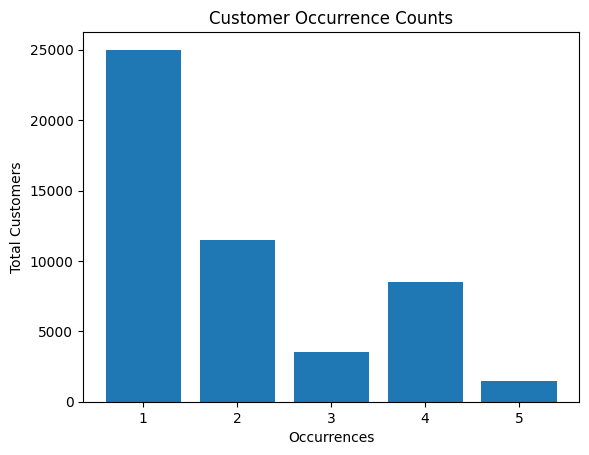

In [11]:
#Customer occurence segmentation
# Initialize counters for each occurrence
occurrences = {5: 0, 4: 0, 3: 0, 2: 0, 1: 0}

# Iterate over rows in the DataFrame
for index, row in unique_customers.iterrows():
    count = row['no_of_customer_occurence']  # Assuming 'no_of_customer_occurence' is the column name
    
    # Check the count and increment the corresponding occurrence counter
    if count >= 5:
        occurrences[5] += 1
    elif count == 4:
        occurrences[4] += 1
    elif count == 3:
        occurrences[3] += 1
    elif count == 2:
        occurrences[2] += 1
    elif count == 1:
        occurrences[1] += 1


x = list(occurrences.keys())
y = list(occurrences.values())

# Plot the bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('Occurrences')
plt.ylabel('Total Customers')
plt.title('Customer Occurrence Counts')

# Display the plot
plt.show()

In [12]:
#Since we have multiple transaction by each user, so we aggregate them

customer_data = (
    dataset.groupby('CustomerID')
    .agg(
        num_transactions=('num_transactions', 'sum'),
        total_order_value=('total_order_value', 'sum'),
        days_between_trans=('days_between_trans', 'mean'),
        repeat_share=('repeat_share','mean'),
        is_dog_user=('is_dog_user', 'mean'),    
    )
    .reset_index()

)
customer_data

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user
0,0,438,47352,30.2,0.354531,0.406175
1,1,428,48654,30.0,0.308091,0.371800
2,2,425,48854,30.0,0.415325,0.372188
3,3,431,48121,29.4,0.306292,0.455935
4,4,431,47711,29.4,0.358195,0.380152
...,...,...,...,...,...,...
49995,49995,15,2397,19.0,0.447562,0.211720
49996,49996,17,2526,18.0,0.382407,0.144070
49997,49997,18,2411,17.0,0.389189,0.242496
49998,49998,16,2584,19.0,0.389447,0.250583


In [13]:
customer_data.insert(3, 'avg_order_value', (customer_data['total_order_value'] / customer_data['num_transactions']).round(2))

In [14]:
customer_data

,CustomerID,num_transactions,total_order_value,avg_order_value,days_between_trans,repeat_share,is_dog_user
0,0,438,47352,108.11,30.2,0.354531,0.406175
1,1,428,48654,113.68,30.0,0.308091,0.371800
2,2,425,48854,114.95,30.0,0.415325,0.372188
3,3,431,48121,111.65,29.4,0.306292,0.455935
4,4,431,47711,110.70,29.4,0.358195,0.380152
...,...,...,...,...,...,...,...
49995,49995,15,2397,159.80,19.0,0.447562,0.211720
49996,49996,17,2526,148.59,18.0,0.382407,0.144070
49997,49997,18,2411,133.94,17.0,0.389189,0.242496
49998,49998,16,2584,161.50,19.0,0.389447,0.250583


<ipython-input-15-77d2b94e3b54>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer_data['num_transactions'], color='r', label='Number of transactions', ax= ax1)
<ipython-input-15-77d2b94e3b54>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer_data['total_order_value'], color='b', 

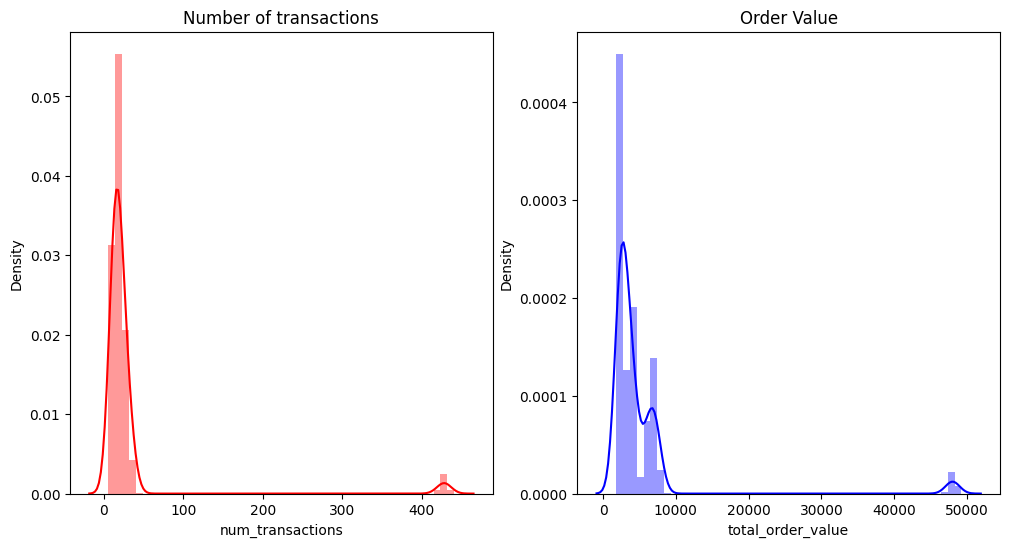

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.distplot(customer_data['num_transactions'], color='r', label='Number of transactions', ax= ax1)
ax1.set_title('Number of transactions')

sns.distplot(customer_data['total_order_value'], color='b', label='Total Order Value', ax=ax2)
ax2.set_title('Order Value')

ax1.legend
ax2.legend



plt.show()



If we sum the total transactions by customers regardless of what label we belong to, we can assume that majority of the majority of the transactions lie between 0 - 100 and order values between 0 - 10000 euros. 

In [16]:
## Unique classes
print(f"Labels: {sorted(dataset['label'].unique())}")

Labels: [0, 1, 2, 3, 4]


In [17]:
## Total customers by each category
label_count = (
    dataset.groupby('label')
    .agg(
        total_customers=('CustomerID', 'count')
    )
    .reset_index()
)

label_count['percentage_of_dataset'] = (label_count['total_customers']/len(dataset)) * 100
label_count

,label,total_customers,percentage_of_dataset
0,0,1500,1.5
1,1,10000,10.0
2,2,25000,25.0
3,3,13500,13.5
4,4,50000,50.0


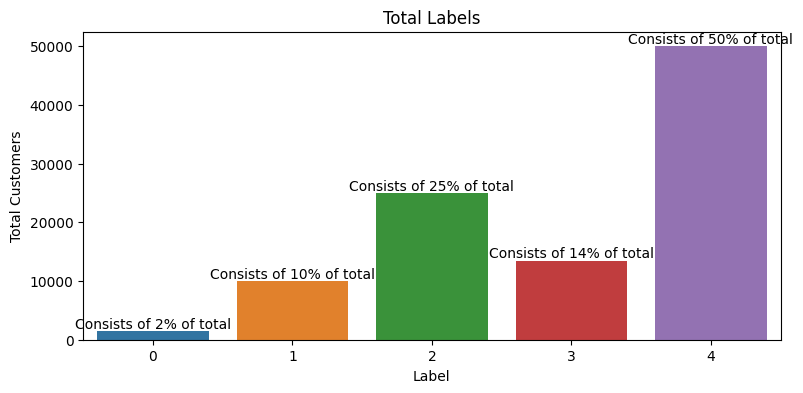

In [18]:
plt.figure(figsize=(9, 4))

# Bar plot for total customers
ax = sns.barplot(data=label_count, x='label', y='total_customers')
ax.set_title('Total Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Total Customers')

# Add percentage information
for index, row in label_count.iterrows():
    label = row['label']
    percentage = row['percentage_of_dataset']
    ax.text(
        index, row['total_customers'], f"Consists of {percentage:.0f}% of total",
        ha='center', va='bottom'
    )

plt.show()


In [19]:
dataset

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
0,1217,399,41145,8,0.563256,0.699630,0
1,7262,7,1454,41,0.255368,0.010605,2
2,26825,12,2137,18,0.397579,0.231064,4
3,21764,16,2582,20,0.439079,0.161709,4
4,217,6,1892,30,0.283809,0.380159,3
...,...,...,...,...,...,...,...
99995,12724,14,1609,31,0.391825,0.132255,3
99996,29372,14,2564,19,0.383645,0.071416,4
99997,3903,1,1170,49,0.116531,0.580196,1
99998,228,1,1074,51,0.074091,0.720686,1


# ML Models

### Data Split

In [20]:
# Data Normalization
dataset_normalized = dataset.copy()
numerical_columns = ['num_transactions', 'total_order_value', 'days_between_trans', 'repeat_share', 'is_dog_user']
scaler = MinMaxScaler()
dataset_normalized[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])
dataset_normalized


,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
0,1217,0.990050,0.995947,0.042553,0.551786,0.699630,0
1,7262,0.014925,0.020954,0.744681,0.235813,0.010605,2
2,26825,0.027363,0.037731,0.255319,0.381758,0.231064,4
3,21764,0.037313,0.048662,0.297872,0.424348,0.161709,4
4,217,0.012438,0.031713,0.510638,0.265000,0.380159,3
...,...,...,...,...,...,...,...
99995,12724,0.032338,0.024761,0.531915,0.375853,0.132255,3
99996,29372,0.032338,0.048220,0.276596,0.367459,0.071416,4
99997,3903,0.000000,0.013977,0.914894,0.093330,0.580196,1
99998,228,0.000000,0.011619,0.957447,0.049775,0.720686,1


In [21]:
#Data preperation
input_data = dataset_normalized.drop(columns=['label'])
output_label = dataset_normalized['label']

x_train, x_test, y_train, y_test = train_test_split(input_data, output_label, test_size=0.25, random_state=42)
print(f"Input training size: {x_train.shape}, Input test size: {x_test.shape}, Labels for training size: {y_train.shape}, Labels for testing size: {y_test.shape}")

Input training size: (75000, 6), Input test size: (25000, 6), Labels for training size: (75000,), Labels for testing size: (25000,)


In [22]:
def model_accuracy(y_test, y_pred):
  #Precision, accuracy, f1_score
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision: ", precision_score(y_test, y_pred, average='weighted')) #Multi-class classification
  print("f1_score: ", f1_score(y_test, y_pred, average='weighted'))
  print(classification_report(y_test, y_pred))

def Confusion_Matrix(y_test, y_pred):
    unique_classes = sorted(set(y_test) | set(y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
    disp.plot()
    plt.show()

### Random Forest

In [23]:
RF = RandomForestClassifier(n_estimators=4, criterion = 'entropy', random_state=42) 
RF = RF.fit(x_train, y_train)
y_predict = RF.predict(x_test)

In [24]:
model_accuracy(y_test, y_predict)

Accuracy: 0.99996
Precision:  0.999960006380603
f1_score:  0.9999599986336313
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       1.00      1.00      1.00      2522
           2       1.00      1.00      1.00      6268
           3       1.00      1.00      1.00      3377
           4       1.00      1.00      1.00     12436

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



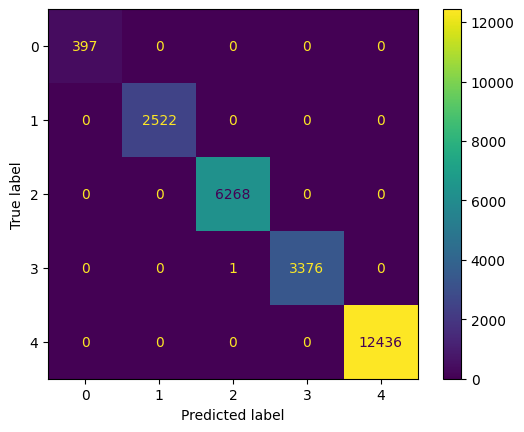

In [25]:
Confusion_Matrix(y_test, y_predict)

### SVM

In [ ]:
## Hyperparameter Tuning - Finding best hyperparameter
##parameters = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
"""
parameters = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
svm = SVC(kernel='rbf', decision_function_shape = 'ovo')
grid_search = GridSearchCV(svm, parameters)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

print(grid_search.best_score_)

y_predict_grid_search = grid_search.predict(x_test)
"""

### DeepL

In [26]:
dataset

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,is_dog_user,label
0,1217,399,41145,8,0.563256,0.699630,0
1,7262,7,1454,41,0.255368,0.010605,2
2,26825,12,2137,18,0.397579,0.231064,4
3,21764,16,2582,20,0.439079,0.161709,4
4,217,6,1892,30,0.283809,0.380159,3
...,...,...,...,...,...,...,...
99995,12724,14,1609,31,0.391825,0.132255,3
99996,29372,14,2564,19,0.383645,0.071416,4
99997,3903,1,1170,49,0.116531,0.580196,1
99998,228,1,1074,51,0.074091,0.720686,1


In [27]:
#Data preperation
dataset_normalized
input_data = dataset_normalized.drop(columns=['label'])
output_label = dataset_normalized['label']

#Split data into training: 70%, valid: 10% and test: 20%

# Split the data into training and test sets (80% for training, 20% for testing)
x_train, x_test, y_train, y_test = train_test_split(input_data, output_label, test_size=0.2, random_state=42)

# Split the training set into training and validation sets 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


print(f"Input training size: {x_train.shape}, \n Input validation size: {x_val.shape}, \n Input test size: {x_test.shape}, \n Labels for training size: {y_train.shape}, \n Labels for validation size: {y_val.shape} \n  Labels for testing size: {y_test.shape}")

Input training size: (70000, 6), 
 Input validation size: (10000, 6), 
 Input test size: (20000, 6), 
 Labels for training size: (70000,), 
 Labels for validation size: (10000,) 
  Labels for testing size: (20000,)


**Reshape Data sets**<br>
Conv1D layer expects input shape in 3D as

  `[batch_size, time_steps, input_dimension]`

However, current data is in the shape of

`[batch_size, features]`

So we have training size of `[75000, 6]`. This means that we have 75000 batches with each batch of 6 features. We can change batch size, for example, to 128. This means that if we have 75000 rows/batches. It will take first 128 rows.

To further understand, please check the following link: https://www.youtube.com/watch?v=JzoIHdkFcQU (I used it to reshape my data and understand Conv1D)

In [29]:
# Reshape the input training and testing data from 2D to 3D

#Train reshape
train_sample_size = x_train.shape[0] #no: of samples in training set -> 75000
train_time_steps = x_train.shape[1] #no: of features in training set -> 6
input_dimension = 1 #Each feature is represented by 1 dimension

"""
All we did above for reshaping training can be done using:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
"""

#Test reshape
test_sample_size = x_test.shape[0] #no: of samples in training set -> 25000
test_time_steps = x_test.shape[1] #no: of features in training set -> 6

#Valid Reshape
val_sample_size = x_val.shape[0] #no: of samples in training set -> 25000
val_time_steps = x_val.shape[1] #no: of features in training set -> 6



x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()


x_train_reshaped = x_train.reshape(train_sample_size, train_time_steps, input_dimension)
x_test_reshaped = x_test.reshape(test_sample_size, test_time_steps, input_dimension)
x_val_reshaped = x_val.reshape(val_sample_size, val_time_steps, input_dimension)

AttributeError: ignored

In [ ]:
print("After reshape train data set shape:\n", x_train_reshaped.shape)
print("1st Sample shape:\n",x_train_reshaped[0].shape)
print("An example sample:\n", x_train_reshaped[0])

In [30]:
model = keras.Sequential([
    keras.layers.Input(shape=(train_time_steps, input_dimension)), #(6, 1)
    keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'), #Conv1D expects input in 3D
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='SparseCategoricalCrossentropy', # Use SparseCategoricalCrossentropy for integer labels
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             96        
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [38]:
model_results = model.fit(x_train_reshaped, y_train, batch_size=64, epochs=5, validation_data=(x_val_reshaped, y_val))

Epoch 1/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0336 - accuracy: 0.9877 - val_loss: 0.0103 - val_accuracy: 0.9971
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0290 - accuracy: 0.9890 - val_loss: 0.0075 - val_accuracy: 0.9975
Epoch 3/5
1094/1094 [==============================] - 7s 6ms/step - loss: 0.0253 - accuracy: 0.9903 - val_loss: 0.0047 - val_accuracy: 0.9984
Epoch 4/5
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0171 - accuracy: 0.9935 - val_loss: 0.0035 - val_accuracy: 0.9987
Epoch 5/5
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 1/5
1094/1094 [==============================] - 8s 7ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 2/5
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 8.6743e-04 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(x_test_reshaped, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

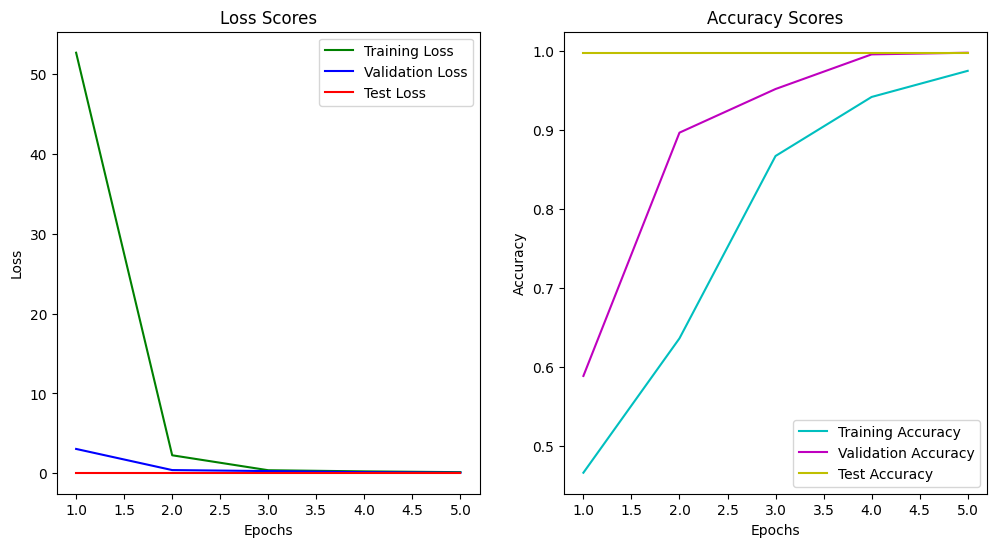

In [33]:
train_loss = model_results.history['loss']
val_loss = model_results.history['val_loss']
train_accuracy = model_results.history['accuracy']
val_accuracy = model_results.history['val_accuracy']


epochs = range(1, len(train_loss) + 1)

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss scores
axs[0].plot(epochs, train_loss, 'g', label='Training Loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation Loss')
axs[0].plot(epochs, [test_loss] * len(epochs), 'r', label='Test Loss')  # Constant test loss
axs[0].set_title('Loss Scores')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy scores
axs[1].plot(epochs, train_accuracy, 'c', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy, 'm', label='Validation Accuracy')
axs[1].plot(epochs, [test_acc] * len(epochs), 'y', label='Test Accuracy')  # Constant test accuracy
axs[1].set_title('Accuracy Scores')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


# Show the plots
plt.show()


In [34]:
y_pred_prob = model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

625/625 [==============================] - 1s 1ms/step


array([4, 1, 3, ..., 2, 4, 2])

In [35]:
print(y_pred.shape) #So we have predicted labels for all 25000 test set

(20000,)


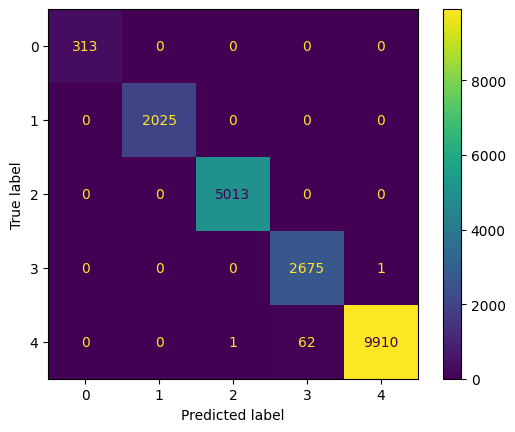

In [36]:
Confusion_Matrix(y_test, y_pred)